# 05-clustering-&-association-rule-mining

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


___ 
## 1. Business Understanding

### Part 1
- Objective: Through the given ``drone_cust_locations`` dataset consisting x and y coordinates finding optimal locations for three drone depots, using the k-means clustering.
- The Dataset contains three columns: ``clientid``, ``x``, ``y``. Clients numerical Id value and the clients location with x- and y-coordinates.


### Part 2
- Objective: Through the given ``drone_prod_groups` dataset find interesting relationships between the product groups it consists of. Reporting clear recommendations how the company should use the resutls of the association rule mining to increase its revenue.
- The Dataset contains ``ID`` - the transaction ID, and ``Prod1, ..., Prod20`` binary variables indicating whether at least one product from a particular group was purchased in the transaction. A value of 1 indicates that at least one product from the group was purchased, while a value of 0 indicates that no products from the group were purchased.


___ 
## 2. Data Understanding

#### 2.1 ``drone_cust_locations.csv `` This dataset contains the locations of customers. The dataset has the following columns:

- clientid - The unique identifier for the customer
- x - The x coordinate of the customer's location, when plotted into a 2D plane
- y - The y coordinate of the customer's location, when plotted into a 2D plane

In [21]:
drone_cust_locations = pd.read_csv('../datasets/drone_cust_locations.csv', sep=';')

drone_cust_locations.head()

,clientid,x,y
0,1,622.771572,164.857623
1,2,416.357298,630.193634
2,3,292.735020,567.333231
3,4,737.211288,166.225676
4,5,540.475375,682.912298


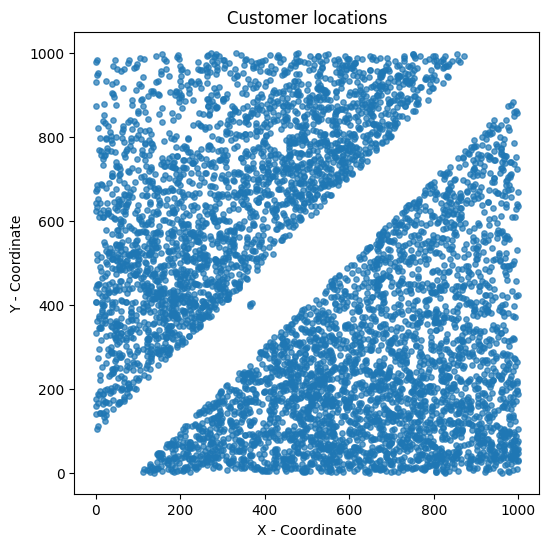

In [22]:
x_coords = drone_cust_locations["x"]
y_coords = drone_cust_locations["y"]

plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, s=15, alpha=0.7)
plt.xlabel("X - Coordinate")
plt.ylabel("Y - Coordinate")
plt.title("Customer locations")
plt.show()

#### 2.2 ``drone_prod_groups.csv`` This dataset contains the sales data for products. The dataset has the following columns:

- ID - The transaction ID
- Prod1, ..., Prod20 - Binary variables indicating whether at least one product from a particular group was purchased in the transaction. A value of 1 indicates that at least one product from the group was purchased, while a value of 0 indicates that no products from the group were purchased.

In [23]:
drone_prod_groups = pd.read_csv('../datasets/drone_prod_groups.csv')
drone_prod_groups.head()

,ID,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,...,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,1,1,1
2,3,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,4,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1


___ 
## 3. Data Preparation

### 3.1 Clustering

In [24]:
# DF for modeling (removes the id column)
X = drone_cust_locations[['x', 'y']]
print(f"Number or NaN values:\n{X.isna().sum()}")

print(X.head(5))

Number or NaN values:
x    0
y    0
dtype: int64
            x           y
0  622.771572  164.857623
1  416.357298  630.193634
2  292.735020  567.333231
3  737.211288  166.225676
4  540.475375  682.912298


### 3.2 Association

___ 
## 4. Modeling

### 4.1 Clustering - Model Selection

Silhouette score: 0.42
Silhouette score: 0.42
Silhouette score: 0.40
Silhouette score: 0.42
Silhouette score: 0.40
Silhouette score: 0.39
Silhouette score: 0.39
Silhouette score: 0.39
Silhouette score: 0.37


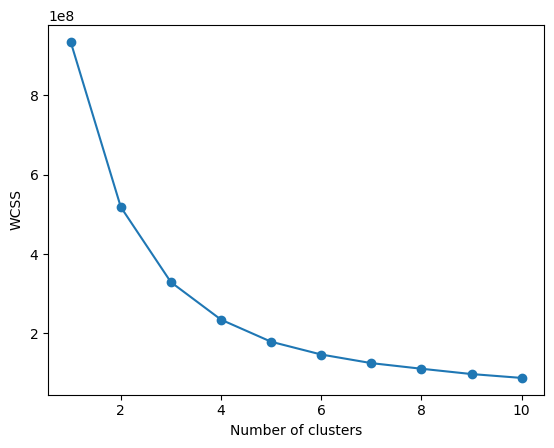

In [25]:
wcss = []

for i in range(1, 11):
    model = KMeans(init='random', n_clusters=i, random_state=123).fit(X)
    if i > 1:
        labels = model.labels_
        print(f"Silhouette score: {silhouette_score(X, labels):.2f}")
    
    wcss.append(model.inertia_)
    
plt.plot(range(1, 11), wcss, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The elbow bend is clearly visible around `k=3` and the silhouette score remains relatively stable `(~0.40-0.42)`.

### 4.2 model with k = 3

The K-Means model partitions customers into three geographically coherent groups.
Cluster centroids represent the optimal depot locations, minimizing within-cluster travel distances.

In [26]:
k = 3
model = KMeans(init='random', n_clusters=k, random_state=123).fit(X)
depot_labels = {
    0: "A",
    1: "B",
    2: "C"
}

drone_cust_locations["nearest_depot"] = model.labels_
drone_cust_locations["nearest_depot"] = drone_cust_locations["nearest_depot"].map(depot_labels)

drone_cust_locations.head(10)

,clientid,x,y,nearest_depot
0,1,622.771572,164.857623,B
1,2,416.357298,630.193634,C
2,3,292.735020,567.333231,A
3,4,737.211288,166.225676,B
4,5,540.475375,682.912298,C
5,6,535.469492,318.439661,B
6,7,640.380050,870.833221,C
7,8,235.772075,359.048203,A
8,9,481.896884,661.491838,C
9,10,730.032789,312.177817,B


In [27]:
drone_depots = pd.DataFrame(model.cluster_centers_, columns=["x", "y"])
drone_depots.index = pd.Index([depot_labels[i] for i in range(len(drone_depots))], name="depot_id")

print("Depot Locations")
drone_depots

Depot Locations


,x,y
depot_id,,
A,194.798554,392.577662
B,697.701861,208.357600
C,555.301076,785.462268


### 4.2 Association

___ 
## 5. Evaluation

Function to plots customer locations grouped by assigned depot and, if available, overlays cluster centroids (depot positions). Adds labels, legend, and title for visualization. Works both ``Kmeans`` and ``Agglomerative Clustering`` cluster visualization

In [28]:
def plot_clusters(drone_cust_loc, model, title):
    labels_txt = drone_cust_loc["nearest_depot"]

    plt.figure(figsize=(7, 7))

    for depot_id in sorted(labels_txt.unique()):
        mask = labels_txt == depot_id
        plt.scatter(
            drone_cust_loc.loc[mask.values, "x"],
            drone_cust_loc.loc[mask.values, "y"],
            s=15, alpha=0.55,
            label=f"Depot {depot_id}"
        )

    if hasattr(model, 'cluster_centers_'):
        centroids = model.cluster_centers_
        plt.scatter(
            centroids[:, 0], centroids[:, 1],
            c="black", s=100, marker="D",
            edgecolor="white", linewidth=1.5,
            label="Depot location"
        )

    plt.xlabel("X - Coordinate")
    plt.ylabel("Y - Coordinate")
    plt.title(title)
    plt.legend()
    plt.show()

### 5.1 Clustering k=3

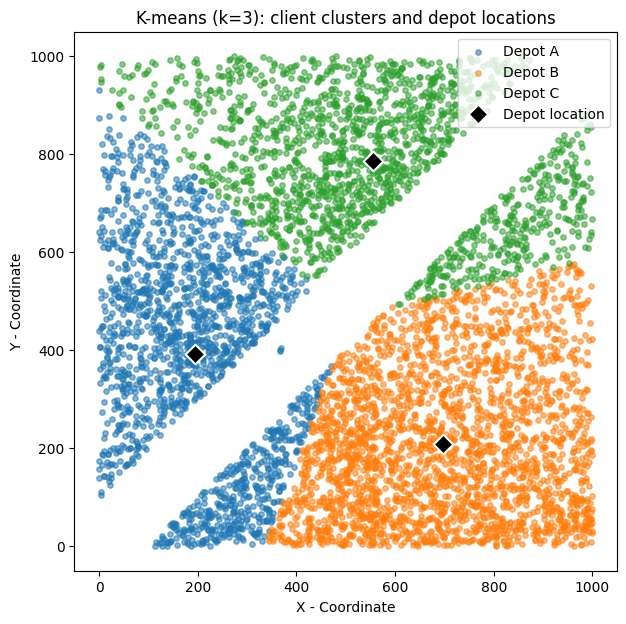

In [29]:
plot_clusters(drone_cust_locations, model, "K-means (k=3): client clusters and depot locations")

In [30]:
print(f"Clients per drone depot")
print(drone_cust_locations["nearest_depot"].value_counts().sort_index())

Clients per drone depot
nearest_depot
A    1756
B    2501
C    1699
Name: count, dtype: int64


### 5.2 Clustering Evaluation (k = 3)
The visualization confirms:
- Compact clusters
- Clear spatial separation
- Centroids positioned near cluster centers
This configuration supports efficient routing and reduced delivery distances.

### 5.3 Clustering k=10

In [31]:
k = 10
model = KMeans(init='random', n_clusters=k, random_state=123).fit(X)
depot_labels = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J"
}

drone_cust_locations["nearest_depot"] = model.labels_
drone_cust_locations["nearest_depot"] = drone_cust_locations["nearest_depot"].map(depot_labels)

drone_depots = pd.DataFrame(model.cluster_centers_, columns=["x", "y"])
drone_depots.index = pd.Index([depot_labels[i] for i in range(len(drone_depots))], name="depot_id")


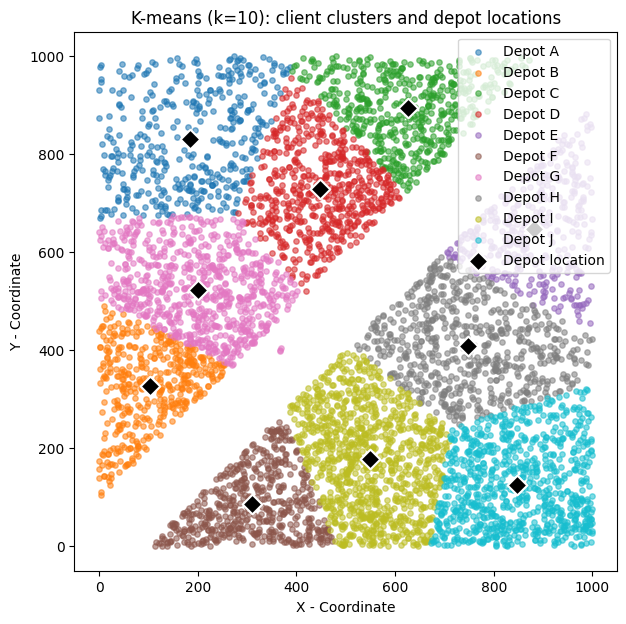

In [32]:
plot_clusters(drone_cust_locations, model, "K-means (k=10): client clusters and depot locations")

With only three depots the clustering time was **200ms**, while with ten depots
it was **260ms** — almost no significant performance loss.

In [33]:
print(f"Clients per drone depot")
print(drone_cust_locations["nearest_depot"].value_counts().sort_index())

Clients per drone depot
nearest_depot
A    400
B    423
C    518
D    578
E    365
F    526
G    719
H    623
I    985
J    819
Name: count, dtype: int64


### 5.4 Clustering Evaluation (k=10)
Increasing to k = 10 creates more granular clusters:

- Smaller service areas
- Reduced distance per client
- Higher infrastructure complexity

However, depot utilization becomes uneven (some depots heavily loaded).

### 5.5 Agglomerative Clustering

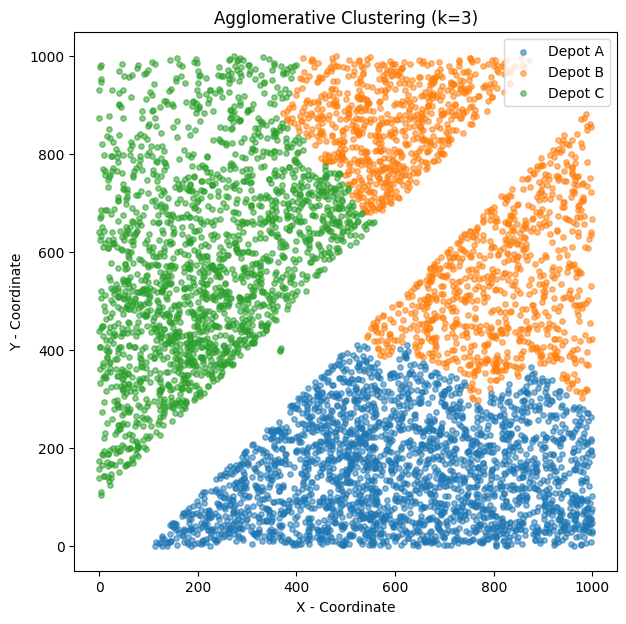

Clients per drone depot
nearest_depot
A    2497
B    1542
C    1917
Name: count, dtype: int64


In [34]:
model_agg3 = AgglomerativeClustering(n_clusters=3)
model_agg3.fit(drone_cust_locations[['x', 'y']])

depot_labels = {0: "A", 1: "B", 2: "C"}
drone_cust_locations["nearest_depot"] = pd.Series(model_agg3.labels_).map(depot_labels).values

plot_clusters(drone_cust_locations, model_agg3, title="Agglomerative Clustering (k=3)")

print("Clients per drone depot")
print(drone_cust_locations["nearest_depot"].value_counts().sort_index())


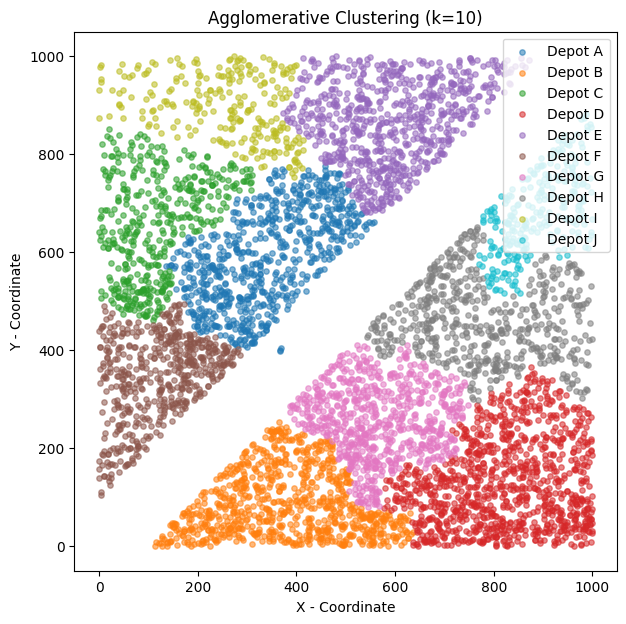

Clients per drone depot
nearest_depot
A    704
B    808
C    432
D    994
E    721
F    524
G    695
H    554
I    257
J    267
Name: count, dtype: int64


In [35]:
# k=10
model_agg10 = AgglomerativeClustering(n_clusters=10)
model_agg10.fit(drone_cust_locations[['x', 'y']])

depot_labels = {0: "A", 1: "B",2: "C",3: "D",
                4:  "E",5: "F",6: "G",7: "H",8: "I",9: "J"}

drone_cust_locations["nearest_depot"] = pd.Series(model_agg10.labels_).map(depot_labels).values

plot_clusters(drone_cust_locations, model_agg10, title="Agglomerative Clustering (k=10)")


print("Clients per drone depot")
print(drone_cust_locations["nearest_depot"].value_counts().sort_index())

### 5.6 Agglomerative Clustering evaluation

Hierarchical clustering produces alternative groupings:

- Clusters differ slightly in shape
- No centroid optimization (unlike K-Means)
- Less directly interpretable for depot placement

Client distribution appears more imbalanced compared to K-Means.

## Part 2: Finding interesting relationships between product groups

## 2. Data understanding

#### 2.1 ``drone_prod_groups.csv ``dataset contains the sales data for products. The dataset has the following columns:
- ``ID - The transaction ID``
- ``Prod1. ..., Prod20`` Binary variables showing whether a product from a group was purchased (1 = yes, 0 = no).

In [42]:
drone_prod_group = pd.read_csv('../datasets/drone_prod_groups.csv')
drone_prod_group.head(5)

,ID,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,...,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,1,1,1
2,3,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,4,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1


#### 2.2

Dropped the ID column and converted binary values to boolean (1 = True, 0 = False) because Apriori requires boolean data count which products were purchased in each transaction

In [43]:
drone_prod_group = drone_prod_group.drop(columns='ID')
drone_prod_group = drone_prod_group.astype(bool)
drone_prod_group.head(5)

,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,Prod10,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,True,True,True,True,True
2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True
3,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True


## 3. Modeling

- ``apriori`` identifies all combinations of products (itemsets) that occur frequently enough across transactions.
- ``min_support=0.03`` only itemsets appearing in at least 3% of transactions are included. We choose 0.03 to balance finding meaningful patterns without generating too many rare or insignificant itemsets.

In [45]:
frequent_itemsets  = apriori(drone_prod_group, min_support=0.03, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.10998,frozenset({Prod1})
1,0.13098,frozenset({ Prod2})
2,0.03271,frozenset({ Prod3})
3,0.03585,frozenset({ Prod4})
4,0.10459,frozenset({ Prod5})
5,0.13499,frozenset({ Prod7})
6,0.16179,frozenset({ Prod8})
7,0.19853,frozenset({ Prod9})
8,0.09336,frozenset({ Prod10})
9,0.10848,frozenset({ Prod11})


 #### 3.1 rule mining
- ``association_rules()`` generates rules from the frequent itemsets found by Apriori. Each rule is of the form:
- ``metric='confidence', min_threshold=0.5`` filters rules to only include those where confidence ≥ 0.5, meaning the consequent occurs in at least 50% of the transactions that contain the antecedent.

In [46]:
rules = association_rules(frequent_itemsets , metric='confidence', min_threshold=0.5)
rules = rules.sort_values(by='confidence', ascending=False)
print(rules.head(5))

                    antecedents           consequents  antecedent support  \
2          frozenset({ Prod15})   frozenset({ Prod9})             0.11880   
3          frozenset({ Prod20})  frozenset({ Prod19})             0.14798   
5  frozenset({ Prod20,  Prod9})  frozenset({ Prod19})             0.03676   
6  frozenset({ Prod9,  Prod19})  frozenset({ Prod20})             0.04996   
4          frozenset({ Prod19})  frozenset({ Prod20})             0.20626   

   consequent support  support  confidence      lift  representativity  \
2             0.19853  0.11145    0.938131  4.725388               1.0   
3             0.20626  0.13476    0.910664  4.415125               1.0   
5             0.20626  0.03345    0.909956  4.411696               1.0   
6             0.14798  0.03345    0.669536  4.524501               1.0   
4             0.14798  0.13476    0.653350  4.415125               1.0   

   leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
2  0.087865   12.9

# Evaluation

#### Top 5 rules

| Antecedent     | Consequent | Confidence | Lift |
| -------------- | ---------- | ---------- | ---- |
| Prod15         | Prod9      | 0.938      | 4.73 |
| Prod20         | Prod19     | 0.911      | 4.42 |
| Prod9 + Prod20 | Prod19     | 0.910      | 4.41 |
| Prod9 + Prod19 | Prod20     | 0.670      | 4.52 |
| Prod19         | Prod20     | 0.653      | 4.42 |

These rules identify the strongest product associations, highlighting opportunities for cross-selling, bundling, and targeted promotions.


___
## 6. Deployment

### 6.1 Model Deployment Decision

#### Model Choice: k = 3 vs. k = 10

k = 3 (Recommended)
- Matches business requirement (three depots)
- Lower operational cost
- Balanced workload
- Sufficient cluster separation

k = 10 (Not recommended for current objective)
- Shorter delivery distances
- Requires additional depots
- Higher fixed and maintenance costs
- Uneven depot utilization

#### Final Decision

Deploy K-Means with k = 3:
- Aligns with strategic plan
- Minimizes infrastructure investment
- Provides stable, interpretable clusters
Future expansion scenarios may revisit k > 3 if demand or service-level constraints change.

### 6.2 Using the Rules for Marketing and Revenue Growth

The Apriori model showed strong relationships between products. These rules shows which items customers frequently buy together.

<br>

<b>1. One product leads to another</b>


By Looking at confidence values of the rules we can see that when ``Prod15`` is bought then customers also buy ``Prod9``
The lift tells that it happens 4.73 times often than by chance <br>
<b> 94% of customers that buy ``Prod15`` also buy ``Prod9`` </b>

To increase revenue
- Recommend ``Prod9`` on ``Prod15`` product page
- Suggest ``Prod9`` during checkout
- Follow-up emails promoting ``Prod9`` to buyers of ``Prod15``

To increase order value

<b>2. Bundling</b>

By looking at the rules we can see that some products are linked to each other
``Prod20 -> Prod19 and Prod19 -> Prod20``

To increase revenue
- Create bundle offer (``Prod19+Prod20``)
- Offer small discount when both are purchased
- Place them next to each other

This encourages customers to buy more in one transaction

<b>3. Targeted recommendations</b>

From the rules we can see that ``Prod9 + Prod20 -> Prod19 (91% Conf.)``
So if customer has ``Prod9`` and ``Prod20`` on their cart there is a high chance that they will also buy ``Prod19``

To increase revenue
- Show real-time recommendations in the cart
- Offer a limited time discount for ``Prod19``
- Use targeted ads for customers who bought Prdo9 and ``Prod20``

To make promotions more personalized


<b>4. High demand products</b>

From rules we can see that ``Prod19`` have a 20.6% support value
It tells us that it is frequently purchased

To increase revenue
- Higher stock values
- Prioritized product
- Marketed

To reduce stockouts and lost sales

### Impact

Applying the rules can
- Increase average basket size
- Improve marketing efficiency
- Increase overall revenue



